In [1]:
import sys
sys.path.insert(0, "../")


import itertools
import numpy as np
from autograd import grad, hessian, numpy as anp
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from triage.triage import Triage

# Huber loss

In [2]:
# Huber Helper

def approx_huber(y, y_hat, delta=5.0):
    """
    Implement the continuous approximation to the Huber loss.
    https://alexisalulema.com/2017/12/07/loss-functions-part-1/
    """

    def huber_loss(y_hat):
        loss = 1.0 + anp.square((y - y_hat) / delta)
        loss = anp.sum(delta * delta * (anp.sqrt(loss) - 1))
        return loss

    h_grad = grad(huber_loss)(y_hat)
    h_hess = hessian(huber_loss)(y_hat)

    # Take the diagonal of the Hessian and make a copy
    # Because xgboost expects a contiguous array
    h_hess = np.diag(h_hess).copy()
    return h_grad, h_hess

# Generate data via the huber contamination model

In [3]:

def generate_data(
    n_samples=1000,
    epsilon=0.1,
    contamination_scale=10,
    beta_0=0,
    beta_1=1,
    noise_scale=1,
    setting="simple",
):
    # Generate x from a uniform distribution
    x = np.random.uniform(0, 10, n_samples)

    # Generate normal noise
    noise = np.random.normal(scale=noise_scale, size=n_samples)

    if setting == "hard":
        # Add contamination to the noise for epsilon fraction of the points
        num_contaminated = int(epsilon * n_samples)
        contamination = np.random.normal(
            scale=contamination_scale, size=num_contaminated
        )

        # Generate y as a linear transformation of x plus noise
        y = beta_0 + beta_1 * x + noise

        contamination = np.random.lognormal(sigma=2, size=num_contaminated)
        y[:num_contaminated] *= 1 + contamination

    if setting == "simple":
        num_contaminated = int(epsilon * n_samples)
        contamination = np.random.normal(
            scale=contamination_scale, size=num_contaminated
        )
        noise[:num_contaminated] += contamination

        # Generate y as a linear transformation of x plus noise
        y = beta_0 + beta_1 * x + noise


    # Return the contaminated indices
    contaminated_indices = np.arange(num_contaminated)

    return x, y, contaminated_indices


def generate_clean_data(
    n_samples=1000,
    epsilon=0.1,
    contamination_scale=10,
    beta_0=0,
    beta_1=1,
    noise_scale=1,
):
    # Generate x from a uniform distribution
    x = np.random.uniform(0, 10, n_samples)

    # Generate normal noise
    noise = np.random.normal(scale=noise_scale, size=n_samples)
    # Generate y as a linear transformation of x plus noise
    y = beta_0 + beta_1 * x + noise

    return x, y

# Run

In [4]:


sweep = [
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
]
nest = 50
seeds = 10

type1 = ["hard"]
type2 = [True]
type3 = ["clean"]


permutations = itertools.product(type1, type2, type3)

for p in tqdm(permutations):

    mse_triage = []
    mae_triage = []

    mse_error = []
    mae_error = []

    mse_huber = []
    mae_huber = []

    # triage + huber
    mse_thuber = []
    mae_thuber = []

    setting = p[0]
    linear = p[1]
    test_setup = p[2]

    title = f"{setting}-{linear}-{test_setup}"

    for epsilon in tqdm(sweep):

        # store results
        triage_mse_sc = []
        error_mse_sc = []
        huber_mse_sc = []
        thuber_mse_sc = []

        for i in range(seeds):

            ############################################
            #
            # Data setup
            #
            ############################################

            x_train, y_train, contaminated_indices = generate_data(
                epsilon=epsilon,
                contamination_scale=10,
                beta_0=0,
                beta_1=1,
                noise_scale=2,
                setting=setting,
            )

            # scale the labels
            from sklearn.preprocessing import StandardScaler

            scaler_labels = StandardScaler()
            scaler_labels.fit(y_train.reshape(-1, 1))

            x, y = x_train, y_train
            if test_setup == "clean":
                X_cal, y_cal = generate_clean_data()
                X_test, y_test = generate_clean_data(n_samples=1000)
            else:
                X_cal, y_cal, contaminated_indices = generate_data(
                    epsilon=epsilon,
                    contamination_scale=10,
                    beta_0=0,
                    beta_1=1,
                    noise_scale=2,
                    setting=setting,
                )

                X_test, y_test, contaminated_indices = generate_data(
                    epsilon=epsilon,
                    contamination_scale=10,
                    beta_0=0,
                    beta_1=1,
                    noise_scale=2,
                    setting=setting,
                )

            n_samples = len(y_train)
            true_labels = []

            for i in range(n_samples):
                if i in contaminated_indices:
                    true_labels.append(1)
                else:
                    true_labels.append(0)

            y_eval = y_train
            X_eval = x_train.reshape(-1, 1)
            X_cal = X_cal.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)

            ############################################
            #
            # Base TRIAGE
            #
            ############################################

            import xgboost as xgb

            if linear:
                learner = xgb.XGBRegressor(
                    n_estimators=nest, booster="gblinear")
            else:
                learner = xgb.XGBRegressor(n_estimators=nest)

            learner.fit(x_train.reshape(-1, 1), y_train)

            triage = Triage(
                X_eval=X_eval,
                y_eval=y_eval,
                X_cal=X_cal,
                y_cal=y_cal,
                nest=nest,
                learner=learner,
            )
            groups_ids, raw_metrics = triage.run()

            metric = raw_metrics["score_metric"]
            errors_array = raw_metrics["errors_array"]
            triage_array = metric

            percentile_thresh = 75
            thresh = 0.33
            conf_thresh_low = thresh
            conf_thresh_high = 1 - thresh
            conf_thresh = 0.5

            uncert = np.mean(metric * (1 - metric), axis=-1)
            confidence = np.mean(metric, axis=-1)

            # Get groups and mainly well-estimated groups
            oe_group = np.where(
                (confidence <= conf_thresh_low)
                & (uncert <= np.percentile(uncert, percentile_thresh))
            )[0]
            ue_group = np.where(
                (confidence >= conf_thresh_high)
                & (uncert <= np.percentile(uncert, percentile_thresh))
            )[0]

            combined_group = np.concatenate((oe_group, ue_group))

            we_group = []
            for id in range(len(confidence)):
                if id not in combined_group:
                    we_group.append(id)

            we_group = np.array(we_group)

            pred_contaminated = []
            n_flagged = 0
            selected_triage = []
            for i in range(len(triage_array)):
                if i in ue_group:
                    pred_contaminated.append(1)
                    n_flagged += 1
                if i in we_group:
                    pred_contaminated.append(0)
                    selected_triage.append(i)
                if i in oe_group:
                    pred_contaminated.append(1)
                    n_flagged += 1
            selected_triage = np.array(selected_triage)

            error_scores = errors_array[:, -1]
            abs_errors = np.abs(error_scores)
            error_ids = np.argsort(abs_errors)[-n_flagged:]

            error_pred = []
            selected_error = []
            for i in range(len(error_scores)):
                if i in error_ids:
                    error_pred.append(1)
                else:
                    error_pred.append(0)
                    selected_error.append(i)

            selected_error = np.array(selected_error)

            ############################################
            #
            # SCULPT W/ TRIAGE & REFIT
            #
            ############################################

            clf_triage = xgb.XGBRegressor(n_estimators=nest)
            clf_triage.fit(X_eval[selected_triage, :],
                           y_train[selected_triage])
            y_pred = clf_triage.predict(X_test)

            # Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)
            triage_mse_sc.append(mse)

            ############################################
            #
            # SCULPT W/ ERROR & REFIT
            #
            ############################################

            # , booster='gblinear')
            clf_error = xgb.XGBRegressor(n_estimators=nest)
            clf_error.fit(X_eval[selected_error, :], y_train[selected_error])
            y_pred = clf_error.predict(X_test)

            # Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)
            error_mse_sc.append(mse)

            ############################################
            #
            # FIT W/ ROBUST HUBER MODEL
            #
            ############################################

            if linear:
                huber = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest, booster="gblinear"
                )
            else:
                huber = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest)

            huber.fit(X_eval, y_train)
            y_pred = huber.predict(X_test)

            # Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)
            huber_mse_sc.append(mse)

            ############################################
            #
            # TRIAGE COMBINED W/ HUBER
            #
            ############################################

            if linear:
                learner = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest, booster="gblinear"
                )
            else:
                learner = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest)

            learner.fit(x_train.reshape(-1, 1), y_train)

            triage = Triage(
                X_eval=X_eval,
                y_eval=y_eval,
                X_cal=X_cal,
                y_cal=y_cal,
                nest=nest,
                learner=learner,
            )
            groups_ids, raw_metrics = triage.run()

            metric = raw_metrics["score_metric"]
            errors_array = raw_metrics["errors_array"]
            triage_array = metric

            uncert = np.mean(metric * (1 - metric), axis=-1)
            confidence = np.mean(metric, axis=-1)

            # Get groups and mainly well-estimated groups
            oe_group = np.where(
                (confidence <= conf_thresh_low)
                & (uncert <= np.percentile(uncert, percentile_thresh))
            )[0]
            ue_group = np.where(
                (confidence >= conf_thresh_high)
                & (uncert <= np.percentile(uncert, percentile_thresh))
            )[0]

            combined_group = np.concatenate((oe_group, ue_group))

            we_group = []
            for id in range(len(confidence)):
                if id not in combined_group:
                    we_group.append(id)

            we_group = np.array(we_group)

            pred_contaminated = []
            n_flagged = 0
            selected_triage = []
            for i in range(len(triage_array)):
                if i in ue_group:
                    pred_contaminated.append(1)
                    n_flagged += 1
                if i in we_group:
                    pred_contaminated.append(0)
                    selected_triage.append(i)
                if i in oe_group:
                    pred_contaminated.append(1)
                    n_flagged += 1
            selected_triage = np.array(selected_triage)

            if linear:
                huber = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest, booster="gblinear"
                )
            else:
                huber = xgb.XGBRegressor(
                    objective=approx_huber, n_estimators=nest)

            huber.fit(X_eval[selected_triage, :], y_train[selected_triage])
            y_pred = huber.predict(X_test)

            # Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)
            thuber_mse_sc.append(mse)

        mse_triage.append(np.mean(triage_mse_sc))

        mse_error.append(np.mean(error_mse_sc))

        mse_huber.append(np.mean(huber_mse_sc))

        mse_thuber.append(np.mean(thuber_mse_sc))

100%|██████████| 8/8 [48:33<00:00, 364.15s/it]
1it [48:33, 2913.19s/it]


# Plot

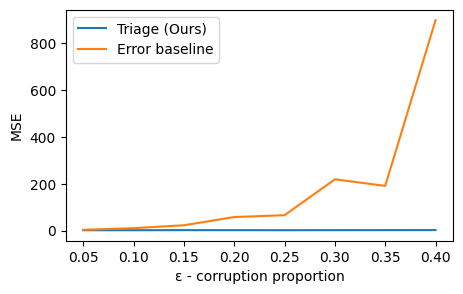

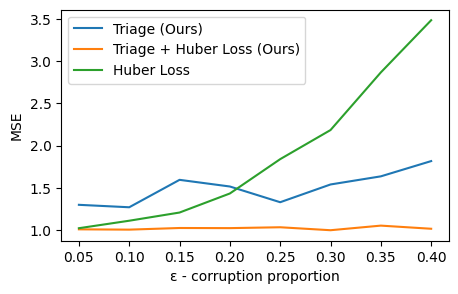

In [5]:
plt.figure(figsize=(5, 3))
n = 0
m = 8
# plt.title(title)
plt.plot(sweep[n:m], mse_triage[n:m], label="Triage (Ours)")
plt.plot(sweep[n:m], mse_error[n:m], label="Error baseline")
plt.xlabel("ε - corruption proportion")
plt.ylabel("MSE")
plt.legend()
# plt.savefig('huber_error.pdf', bbox_inches="tight")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(sweep[n:m], mse_triage[n:m], label="Triage (Ours)")
plt.plot(sweep[n:m], mse_thuber[n:m], label="Triage + Huber Loss (Ours)")
plt.plot(sweep[n:m], mse_huber[n:m], label="Huber Loss")

plt.xlabel("ε - corruption proportion")
plt.ylabel("MSE")
plt.legend()
# plt.savefig('huber_combined.pdf', bbox_inches="tight")
plt.show()